In [9]:
# Upload the local data file to colab
from google.colab import files
uploaded = files.upload()

Saving glioma_mskcc_2019_clinical_data_simpler.csv to glioma_mskcc_2019_clinical_data_simpler.csv


In [10]:
# Installation of necessary libraries
!pip install bravado
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geneview
!pip install gprofiler-official
!pip install statsmodels
!pip install scikit-learn

In [11]:
# import libraries to use
import bravado
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geneview
from gprofiler import GProfiler
import statsmodels.api as sm
from sklearn import datasets, model_selection, metrics
import math


In [12]:
# Read the data in the glioma_mskcc_2019_clinical_data_simpler.csv file into a dataframe
clinical = pd.read_csv('glioma_mskcc_2019_clinical_data_simpler.csv', sep=",")
# Read the data in the data_mutations_short.csv file into a dataframe
mutations = pd.read_csv('data_mutations_short.csv', sep=",")
# Read the data in the Mutated_Genes.csv file into a dataframe
genes = pd.read_csv('Mutated_Genes.csv', sep=",")

In [13]:
# Parsing pathways csv
# Load the CSV file with default separator
pathways = pd.read_csv('pathways.csv')

# Step 1: Split the 'Pathway,Genes' column into 'Pathway' and 'Genes' based on the first comma
pathways[['Pathway', 'Genes']] = pathways['Pathway,Genes'].str.split(',', n=1, expand=True)

# Step 2: Remove the original 'Pathway,Genes' column (not needed anymore)
pathways.drop(columns=['Pathway,Genes'], inplace=True)

# Step 3: Remove quotes and split the 'Genes' into individual gene names
pathways['Genes'] = pathways['Genes'].str.replace('"', '').str.split(', ')

# Step 4: Explode the 'Genes' column so that each gene gets its own row
pathways_exploded = pathways.explode('Genes').reset_index(drop=True)

# Step 5: Clean up any leading/trailing spaces and convert gene names to uppercase
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 6: Show the cleaned and exploded pathways DataFrame
pathways_exploded

,Pathway,Genes
0,Astrocytic drivers,ATRX
1,Astrocytic drivers,TP53
2,Cell-cycle control,CCND2
3,Cell-cycle control,CDK4
4,Cell-cycle control,CDK6
5,Cell-cycle control,CDKN1A
6,Cell-cycle control,CDKN2A/B
7,Cell-cycle control,RB1
8,Chromatin remodeling,ARID1A
9,Chromatin remodeling,ARID1B


In [14]:
# show clinical
clinical

,Study ID,Patient ID,Sample ID,Actionable Lesion1,Diagnosis Age,Cancer Type,Cancer Type Detailed,Enhancing,Gene Panel,Histology,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
0,glioma_mskcc_2019,P-0000223,P-0000223-T01-IM3,No,17.0,Glioma,Diffuse Astrocytoma,Yes,IMPACT341,Anaplastic astrocytoma,...,1:DECEASED,glioma_mskcc_2019_552,116.0,1:PROGRESSION,1,Recurrence,Female,5.545777,"Diffuse astrocytoma, IDH-mutant",G3
1,glioma_mskcc_2019,P-0000378,P-0000378-T01-IM3,No,55.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_141,NaN,NaN,1,Primary,Male,5.545777,"Glioblastoma, IDH-wildtype",G4
2,glioma_mskcc_2019,P-0000486,P-0000486-T01-IM3,No,35.0,Glioma,Oligodendroglioma,No,IMPACT341,Anaplastic oligodendroglioma,...,0:LIVING,glioma_mskcc_2019_651,113.0,0:CENSORED,1,Recurrence,Female,3.327466,"Oligodendroglioma, IDH-mutant and 1p/19q-codel...",G3
3,glioma_mskcc_2019,P-0000500,P-0000500-T01-IM3,Yes,42.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_209,NaN,NaN,1,Recurrence,Male,115.352151,"Glioblastoma, IDH-wildtype",G4
4,glioma_mskcc_2019,P-0000572,P-0000572-T01-IM3,No,59.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_111,NaN,NaN,1,Primary,Male,7.764087,"Glioblastoma, IDH-wildtype",G4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,glioma_mskcc_2019,TRF079053,TRF079053,No,39.0,Glioma,Diffuse Astrocytoma,No,FoundationOneT7,Diffuse astrocytoma,...,0:LIVING,glioma_mskcc_2019_492,22.3,0:CENSORED,1,Primary,Female,6.677785,"Diffuse astrocytoma, IDH-mutant",G2
847,glioma_mskcc_2019,TRF079056,TRF079056,No,28.0,Glioma,Glioblastoma Multiforme,Yes,FoundationOneT7,Glioblastoma,...,0:LIVING,glioma_mskcc_2019_415,12.1,1:PROGRESSION,1,Primary,Male,6.677785,"Glioblastoma, IDH-mutant",G4
848,glioma_mskcc_2019,TRF083668,TRF083668,No,36.0,Glioma,Anaplastic Oligodendroglioma,No,FoundationOneT7,Anaplastic oligodendroglioma,...,0:LIVING,glioma_mskcc_2019_553,83.1,0:CENSORED,1,Primary,Female,2.504169,"Anaplastic oligodendroglioma, IDH-mutant and 1...",G3
849,glioma_mskcc_2019,TRF102171,TRF102171,No,55.0,Glioma,Glioblastoma Multiforme,NaN,FoundationOneT7,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_250,19.9,1:PROGRESSION,1,Primary,Female,9.181955,"Glioblastoma, IDH-wildtype",G4


In [15]:
# show mutations
mutations

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0
...,...,...,...,...,...,...
8900,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0
8901,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0
8902,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0
8903,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0


In [16]:
# information about dataframes
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Study ID                                851 non-null    object 
 1   Patient ID                              851 non-null    object 
 2   Sample ID                               851 non-null    object 
 3   Actionable Lesion1                      850 non-null    object 
 4   Diagnosis Age                           850 non-null    float64
 5   Cancer Type                             851 non-null    object 
 6   Cancer Type Detailed                    851 non-null    object 
 7   Enhancing                               343 non-null    object 
 8   Gene Panel                              851 non-null    object 
 9   Histology                               851 non-null    object 
 10  MGMT Status                             572 non-null    object

In [17]:
# information about dataframes
mutations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8905 entries, 0 to 8904
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hugo_Symbol           8905 non-null   object 
 1   Entrez_Gene_Id        8824 non-null   float64
 2   Consequence           8905 non-null   object 
 3   Tumor_Sample_Barcode  8905 non-null   object 
 4   HGVSp_Short           8308 non-null   object 
 5   Hotspot               8905 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 417.5+ KB


In [18]:
# information about dataframes
genes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Gene                             485 non-null    object 
 1   MutSig(Q-value)                  0 non-null      float64
 2   # Mut                            485 non-null    int64  
 3   #                                485 non-null    int64  
 4   Profiled Samples                 485 non-null    int64  
 5   Freq                             485 non-null    object 
 6   Is Cancer Gene (source: OncoKB)  485 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 26.6+ KB


In [ ]:
#!pip install biopython mygene pandas

#import requests
#import pandas as pd
#from Bio.KEGG import REST
#import mygene

# Initialize MyGene.info for fetching NCBI Gene IDs
mg = mygene.MyGeneInfo()

# Assuming your DataFrame is called 'genes' and the first column contains gene names
gene_list = genes.iloc[:, 0].tolist()  # Extract the first column as a list of genes

# Function to get NCBI Gene ID using MyGene.info based on gene symbols
def get_ncbi_gene_id(gene):
    try:
        result = mg.query(gene, species='human', fields='entrezgene')
        return str(result['hits'][0]['entrezgene']) if 'hits' in result and result['hits'] else None
    except:
        return None  # Return None if no valid ID is found

# Function to query KEGG for pathways related to a gene using NCBI Gene ID
def get_kegg_pathways_for_gene(gene_id):
    try:
        # Query KEGG for the gene's pathways using NCBI Gene ID
        result = REST.kegg_link("pathway", f"hsa:{gene_id}").read()

        # Extract pathway IDs from KEGG result
        pathway_ids = [line.split('\t')[1] for line in result.strip().split('\n')]

        # Get the pathway names by querying KEGG for each pathway ID
        pathway_names = []
        for pathway_id in pathway_ids[:3]:  # Limit to the first 3 pathways
            pathway_info = REST.kegg_get(pathway_id).read()
            # Extract the pathway name from the KEGG entry
            for line in pathway_info.splitlines():
                if line.startswith('NAME'):
                    # Clean pathway name and remove '- Homo sapiens (human)' part
                    pathway_name = line.split('        ')[-1].split(' - ')[0]
                    pathway_names.append(pathway_name)
                    break

        return pathway_names
    except Exception as e:
        return []  # Return an empty list if an error occurs

# Dictionary to store gene-to-pathway mappings
gene_pathway_mapping = {}

# Loop through each gene, get NCBI Gene ID, and fetch pathways from KEGG
for gene in gene_list:
    gene_id = get_ncbi_gene_id(gene)  # Fetch NCBI Gene ID automatically
    if gene_id:  # Only proceed if a valid gene ID is found
        pathways = get_kegg_pathways_for_gene(gene_id)
        gene_pathway_mapping[gene] = pathways

# Convert the gene-pathway mapping into a DataFrame
gene_pathway_df = pd.DataFrame(list(gene_pathway_mapping.items()), columns=['Gene', 'Pathways'])

# Print the results
print(gene_pathway_df)

In [19]:
# Assuming the 'mutations' and 'pathways_exploded' DataFrames are already loaded

# Step 1: Clean and standardize 'Hugo_Symbol' in the 'mutations' DataFrame
mutations['Hugo_Symbol'] = mutations['Hugo_Symbol'].str.strip().str.upper()

# Step 2: Clean and standardize the 'Genes' in the 'pathways_exploded' DataFrame
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 3: Check if TERT exists in both DataFrames before merging
print("TERT in mutations:", 'TERT' in mutations['Hugo_Symbol'].values)
print("TERT in pathways:", 'TERT' in pathways_exploded['Genes'].values)

# Step 4: Merge the 'mutations' and 'pathways_exploded' DataFrames
mutations_with_pathways = pd.merge(
    mutations,              # The mutations DataFrame
    pathways_exploded,       # The exploded pathways DataFrame
    left_on='Hugo_Symbol',   # Column in mutations that contains gene names
    right_on='Genes',        # Column in pathways that contains gene names
    how='left'               # Use 'left' join to keep all mutations, even if no pathway is found
)

# Step 5: Fill missing pathways with 'none'
mutations_with_pathways['Pathway'].fillna('none', inplace=True)

# Step 6: Drop the 'Genes' column from the resulting DataFrame since it's redundant
mutations_with_pathways.drop(columns=['Genes'], inplace=True)

# Step 7: Show the row where Hugo_Symbol is 'TERT' to verify pathway assignment
print(mutations_with_pathways[mutations_with_pathways['Hugo_Symbol'] == 'TERT'])

TERT in mutations: True
TERT in pathways: True
     Hugo_Symbol  Entrez_Gene_Id            Consequence Tumor_Sample_Barcode  \
518         TERT          7015.0       missense_variant    P-0000944-T01-IM3   
519         TERT          7015.0       missense_variant    P-0000944-T01-IM3   
1255        TERT          7015.0       missense_variant    P-0009634-T01-IM5   
1260        TERT          7015.0       missense_variant    P-0003344-T01-IM5   
1402        TERT          7015.0       missense_variant    P-0000500-T01-IM3   
...          ...             ...                    ...                  ...   
9666        TERT          7015.0  upstream_gene_variant    P-0003079-T01-IM5   
9667        TERT          7015.0  upstream_gene_variant            TRF056398   
9668        TERT          7015.0  upstream_gene_variant    P-0002452-T01-IM3   
9669        TERT          7015.0  upstream_gene_variant    P-0004609-T01-IM5   
9670        TERT          7015.0  upstream_gene_variant    P-0004771-T01-

In [20]:
mutations_with_pathways

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0,RTK-RAS
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0,none
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0,NOTCH pathway
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0,none
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0,none
...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance


In [52]:
# Step 1: Make sure the 'Pathway' column is in the mutations DataFrame before merging
# Verify that mutations DataFrame contains 'Pathway' column
if 'Pathway' not in mutations_with_pathways.columns:
    print("Error: 'Pathway' column is missing in the mutations DataFrame!")
else:
    # Proceed with the merge if 'Pathway' is present

    # Step 2: Merge the mutations DataFrame with the clinical DataFrame
    merged_df = pd.merge(
        mutations_with_pathways,           # The mutations DataFrame with 'Pathway'
        clinical,                          # The clinical DataFrame
        left_on='Tumor_Sample_Barcode',    # Column from mutations
        right_on='Sample ID',              # Column from clinical
        how='left'                         # Use 'left' join to keep all rows from mutations
    )


    # Step 3: Display a summary of the merged DataFrame
    print(f"Total rows in merged DataFrame: {len(merged_df)}")
    print(f"Columns in merged DataFrame: {merged_df.columns}")

    # Step 4: Show the first few rows to ensure 'Pathway' column is intact
    print(merged_df[['Patient ID', 'Tumor_Sample_Barcode', 'Sample ID', 'Pathway']].head())

    # Step 5: Find unmatched rows (rows where 'Sample ID' in clinical is missing)
    unmatched_rows = merged_df[merged_df['Sample ID'].isnull()]
    print(f"Number of unmatched rows: {len(unmatched_rows)}")
    print("Unmatched rows:\n", unmatched_rows[['Tumor_Sample_Barcode', 'Pathway']].head())


Total rows in merged DataFrame: 9671
Columns in merged DataFrame: Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Consequence', 'Tumor_Sample_Barcode',
       'HGVSp_Short', 'Hotspot', 'Pathway', 'Study ID', 'Patient ID',
       'Sample ID', 'Actionable Lesion1', 'Diagnosis Age', 'Cancer Type',
       'Cancer Type Detailed', 'Enhancing', 'Gene Panel', 'Histology',
       'MGMT Status', 'Mutation Count', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status',
       'Patient Display Name', 'Progress Free Survival (Months)',
       'Progression Free Status', 'Number of Samples Per Patient',
       'Sample Type', 'Sex', 'TMB (nonsynonymous)',
       'WHO Classification of Diagnostic Tumor', 'WHO Grade'],
      dtype='object')
  Patient ID Tumor_Sample_Barcode Sample ID        Pathway
0        NaN    P-0010578-T01-IM5       NaN        RTK-RAS
1        NaN    P-0010578-T01-IM5       NaN           none
2        NaN    P-0010578-T01-IM5       NaN  NOTCH pathway
3        NaN  

In [50]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9671 entries, 0 to 9670
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Hugo_Symbol                             9671 non-null   object 
 1   Entrez_Gene_Id                          9590 non-null   float64
 2   Consequence                             9671 non-null   object 
 3   Tumor_Sample_Barcode                    9671 non-null   object 
 4   HGVSp_Short                             9074 non-null   object 
 5   Hotspot                                 9671 non-null   int64  
 6   Pathway                                 9671 non-null   object 
 7   Study ID                                7674 non-null   object 
 8   Patient ID                              7674 non-null   object 
 9   Sample ID                               7674 non-null   object 
 10  Actionable Lesion1                      7667 non-null   obje

In [51]:
merged_df

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway,Study ID,Patient ID,Sample ID,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0,RTK-RAS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0,NOTCH pathway,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0003079,P-0003079-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_94,NaN,NaN,1.0,Primary,Male,1.957439,"Glioblastoma, IDH-wildtype",G4
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance,glioma_mskcc_2019,TRF056398,TRF056398,...,1:DECEASED,glioma_mskcc_2019_95,7.96,1:PROGRESSION,1.0,Primary,Male,5.008339,"Glioblastoma, IDH-wildtype",G4
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0002452,P-0002452-T01-IM3,...,1:DECEASED,glioma_mskcc_2019_96,6.28,1:PROGRESSION,1.0,Primary,Female,2.218311,"Glioblastoma, IDH-wildtype",G4
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0004609,P-0004609-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_97,NaN,NaN,1.0,Primary,Male,3.914879,"Glioblastoma, IDH-wildtype",G4


In [53]:
# Step 1: Clean and standardize the 'Tumor_Sample_Barcode' and 'Sample ID' columns
mutations['Tumor_Sample_Barcode'] = mutations['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical['Sample ID'] = clinical['Sample ID'].str.strip().str.upper()

# Step 2: Identify matched samples
matched_samples = mutations[mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
matched_count = len(matched_samples)

# Step 3: Identify unmatched samples
unmatched_samples = mutations[~mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
unmatched_count = len(unmatched_samples)

# Step 4: Optional - Identify partially matched samples (trim the sample barcode)
# Here we assume the first 10 characters might help find partial matches (adjust as needed)
mutations['Trimmed_Barcode'] = mutations['Tumor_Sample_Barcode'].str[:10]  # Adjust length based on actual data
partially_matched_samples = mutations[mutations['Trimmed_Barcode'].isin(clinical['Sample ID'])]
partially_matched_count = len(partially_matched_samples)

# Step 5: Print out the results
print(f"Total samples in mutations: {len(mutations)}")
print(f"Matched samples: {matched_count}")
print(f"Unmatched samples: {unmatched_count}")

Total samples in mutations: 8905
Matched samples: 7036
Unmatched samples: 1869


In [23]:
!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import process
import pandas as pd

# Step 1: Clean and standardize the 'Tumor_Sample_Barcode' in mutations and 'Sample ID' in clinical
mutations['Tumor_Sample_Barcode'] = mutations['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical['Sample ID'] = clinical['Sample ID'].str.strip().str.upper()

# Step 2: Identify matched samples
matched_samples = mutations[mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
matched_count = len(matched_samples)

# Step 3: Identify unmatched samples
unmatched_samples = mutations[~mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
unmatched_count = len(unmatched_samples)

# Step 4: Fuzzy match unmatched samples to 'Sample ID' in clinical
def fuzzy_match(sample_barcode, sample_id_list, threshold=90):
    """ Returns the closest matches with a score above the threshold """
    match = process.extractOne(sample_barcode, sample_id_list, score_cutoff=threshold)
    return match[0] if match else None

# Apply fuzzy matching to the unmatched samples
unmatched_samples['Fuzzy_Match'] = unmatched_samples['Tumor_Sample_Barcode'].apply(
    lambda x: fuzzy_match(x, clinical['Sample ID'].tolist())
)

# Step 5: Count partially matched samples (those that got a fuzzy match)
partially_matched_samples = unmatched_samples[unmatched_samples['Fuzzy_Match'].notna()]
partially_matched_count = len(partially_matched_samples)

# Step 6: Print out the results
print(f"Total samples in mutations: {len(mutations)}")
print(f"Matched samples: {matched_count}")
print(f"Unmatched samples: {unmatched_count}")
print(f"Partially matched samples (fuzzy match): {partially_matched_count}")

# Optionally, save partially matched samples for review

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.2 MB/s eta 0:00:00
Total samples in mutations: 8905
Matched samples: 7036
Unmatched samples: 1869
Partially matched samples (fuzzy match): 660


<ipython-input-23-a489272dc8ee>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_samples['Fuzzy_Match'] = unmatched_samples['Tumor_Sample_Barcode'].apply(


In [54]:

# Optionally drop rows with missing clinical data
merged_df_clean = merged_df.dropna(subset=['Sample ID'])

# Check the number of remaining rows after dropping NAs
print(f"Remaining samples after dropping unmatched rows: {len(merged_df_clean)}")

Remaining samples after dropping unmatched rows: 7674


In [55]:
merged_df_clean

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway,Study ID,Patient ID,Sample ID,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
8,DICER1,23405.0,missense_variant,P-0003850-T01-IM5,p.I1043T,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
9,EGFR,1956.0,missense_variant,P-0003850-T01-IM5,p.R222C,0,RTK-RAS,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
10,RASA1,5921.0,missense_variant,P-0003850-T01-IM5,p.E333Q,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
11,HRAS,3265.0,missense_variant,P-0005696-T01-IM5,p.Q61L,0,RTK-RAS,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_100,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4
12,NOTCH4,4855.0,missense_variant,P-0005696-T01-IM5,p.G148E,0,none,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_100,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0003079,P-0003079-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_94,NaN,NaN,1.0,Primary,Male,1.957439,"Glioblastoma, IDH-wildtype",G4
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance,glioma_mskcc_2019,TRF056398,TRF056398,...,1:DECEASED,glioma_mskcc_2019_95,7.96,1:PROGRESSION,1.0,Primary,Male,5.008339,"Glioblastoma, IDH-wildtype",G4
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0002452,P-0002452-T01-IM3,...,1:DECEASED,glioma_mskcc_2019_96,6.28,1:PROGRESSION,1.0,Primary,Female,2.218311,"Glioblastoma, IDH-wildtype",G4
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0004609,P-0004609-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_97,NaN,NaN,1.0,Primary,Male,3.914879,"Glioblastoma, IDH-wildtype",G4


In [56]:
# Save the cleaned DataFrame
merged_df_clean.to_csv('merged_mutations_clinical_clean.csv', index=False)

In [57]:
merged_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7674 entries, 8 to 9670
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Hugo_Symbol                             7674 non-null   object 
 1   Entrez_Gene_Id                          7612 non-null   float64
 2   Consequence                             7674 non-null   object 
 3   Tumor_Sample_Barcode                    7674 non-null   object 
 4   HGVSp_Short                             7175 non-null   object 
 5   Hotspot                                 7674 non-null   int64  
 6   Pathway                                 7674 non-null   object 
 7   Study ID                                7674 non-null   object 
 8   Patient ID                              7674 non-null   object 
 9   Sample ID                               7674 non-null   object 
 10  Actionable Lesion1                      7667 non-null   object 
 

In [58]:
import pandas as pd

# Step 1: Filter for patients with IDH1 or IDH2 mutations (group 1: IDH mutant)
idh_mutant = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]

# Step 2: Get unique Patient IDs for IDH mutants
idh_mutant_patients = idh_mutant['Patient ID'].unique()

# Step 3: Identify IDH WT (wild-type) patients (group 2: not IDH1 or IDH2)
idh_wt = merged_df_clean[~merged_df_clean['Patient ID'].isin(idh_mutant_patients)]

# Step 4: Count the number of unique Patient IDs in each group
idh_mutant_count = len(idh_mutant_patients)
idh_wt_count = len(idh_wt['Patient ID'].unique())

# Step 5: Print the results
print(f"Number of IDH mutant patients: {idh_mutant_count}")
print(f"Number of IDH WT patients: {idh_wt_count}")

Number of IDH mutant patients: 312
Number of IDH WT patients: 529


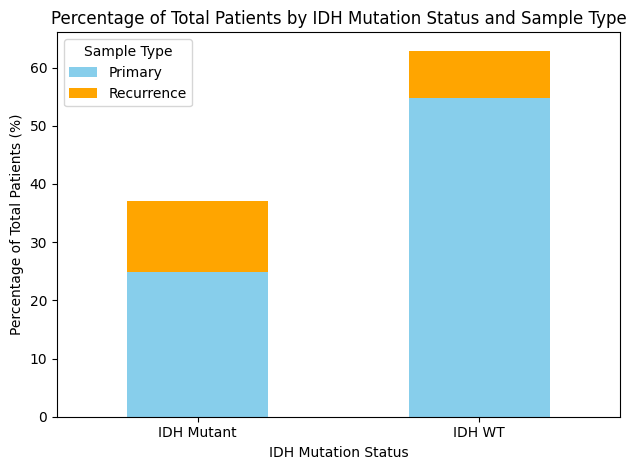

In [101]:
import matplotlib.pyplot as plt

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients (those with IDH1 or IDH2 mutations)
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status to each patient based on 'Patient ID'
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' and count the number of patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients relative to the total number of patients in the dataset
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure the correct order of 'Sample Type' (Primary first, Recurrence second)
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a stacked bar plot with the percentage of total patients on the Y-axis
grouped_percentage.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])

# Step 8: Customize the plot labels and formatting
plt.title('Percentage of Total Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')
plt.tight_layout()

# Step 9: Show the plot
plt.show()


P-values: {'Primary': 1.659953987802262e-147, 'Recurrence': 7.581727399256121e-39}


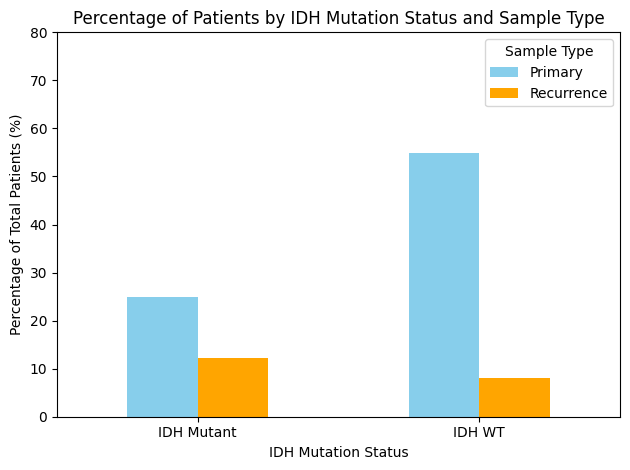

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' to count patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure correct order of 'Sample Type'
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a bar plot
ax = grouped_percentage.plot(kind='bar', stacked=False, color=['skyblue', 'orange'])

# Step 8: Prepare for Mann-Whitney U tests
p_values = {}
sample_types = ['Primary', 'Recurrence']

# Step 9: Mann-Whitney U tests for each sample type
for sample in sample_types:
    group_mutant = [grouped_counts.loc['IDH Mutant', sample]] * grouped_counts.loc['IDH Mutant', sample]
    group_wt = [grouped_counts.loc['IDH WT', sample]] * grouped_counts.loc['IDH WT', sample]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_mutant, group_wt, alternative='two-sided')
    p_values[sample] = p_value

# Debug: Print p-values
print("P-values:", p_values)

# Step 10: Customize the plot
plt.title('Percentage of Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')

# Add p-values to the legend
p_values_text = [f"{sample}: {p_values[sample]:.2e}" for sample in sample_types]
plt.legend(title='Sample Type', labels=['Primary', 'Recurrence'] + p_values_text)

plt.ylim(0, 80)  # Adjust the y-axis limit
plt.tight_layout()

# Step 11: Show the plot
plt.show()


P-values: {'Primary': 1.659953987802262e-147, 'Recurrence': 7.581727399256121e-39}


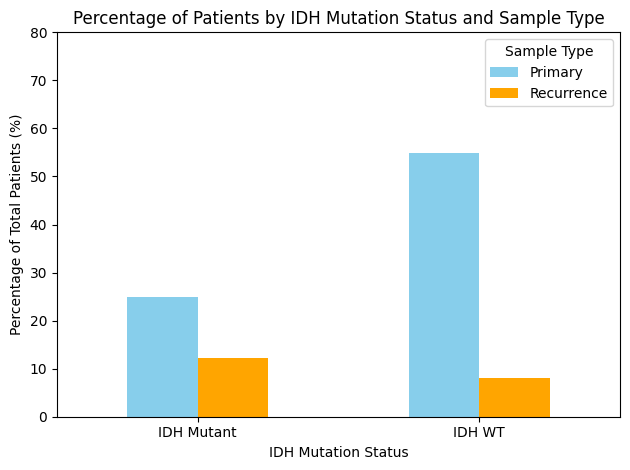

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' to count patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure correct order of 'Sample Type'
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a bar plot
ax = grouped_percentage.plot(kind='bar', stacked=False, color=['skyblue', 'orange'])

# Step 8: Prepare for Mann-Whitney U tests
p_values = {}
sample_types = ['Primary', 'Recurrence']

# Step 9: Mann-Whitney U tests for each sample type
for sample in sample_types:
    group_mutant = [grouped_counts.loc['IDH Mutant', sample]] * grouped_counts.loc['IDH Mutant', sample]
    group_wt = [grouped_counts.loc['IDH WT', sample]] * grouped_counts.loc['IDH WT', sample]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_mutant, group_wt, alternative='two-sided')
    p_values[sample] = p_value

# Debug: Print p-values
print("P-values:", p_values)

# Step 10: Customize the plot
plt.title('Percentage of Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')

# Add p-values to the legend
p_values_text = [f"{sample}: {p_values[sample]:.2e}" for sample in sample_types]
plt.legend(title='Sample Type', labels=['Primary', 'Recurrence'] + p_values_text)

plt.ylim(0, 80)  # Adjust the y-axis limit
plt.tight_layout()

# Step 11: Show the plot
plt.show()


<ipython-input-118-8c9909eb3e70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


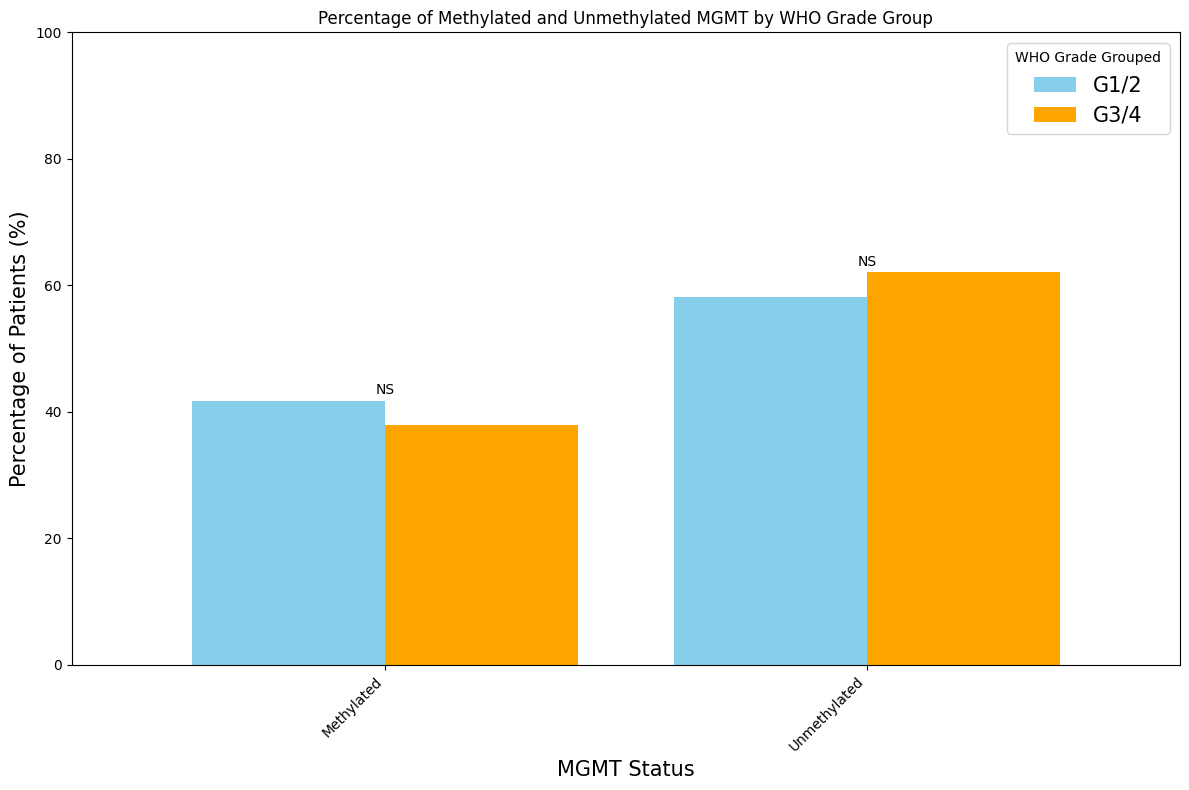

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Step 1: Filter out 'Indeterminate' from the WHO Grade column and group WHO Grades
filtered_df = merged_df_clean[merged_df_clean['WHO Grade'] != 'Indeterminate']
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})

# Step 2: Count unique patients in each MGMT status and WHO Grade Grouped
mgmt_counts = filtered_df.groupby(['MGMT Status', 'WHO Grade Grouped'])['Patient ID'].nunique().unstack(fill_value=0)

# Step 3: Calculate the percentage of patients in each group
total_patients = mgmt_counts.sum(axis=0)
mgmt_perc = mgmt_counts.div(total_patients, axis=1) * 100

# Step 4: Perform t-tests to compare the distributions
t_test_results = {}
for mgmt_status in mgmt_counts.index:
    g1_2_count = mgmt_counts.loc[mgmt_status, 'G1/2']
    g3_4_count = mgmt_counts.loc[mgmt_status, 'G3/4']

    # Prepare lists for t-test
    g1_2_data = [1] * g1_2_count
    g3_4_data = [1] * g3_4_count

    # Perform t-test if both groups have data
    if g1_2_count > 0 and g3_4_count > 0:
        t_stat, p_value = ttest_ind(g1_2_data, g3_4_data, equal_var=False)
        t_test_results[mgmt_status] = p_value
    else:
        t_test_results[mgmt_status] = float('nan')  # Use NaN for missing data

# Step 5: Plot the data
ax = mgmt_perc.plot(kind='bar', figsize=(12, 8), width=0.8,['skyblue', 'orange'] )

# Step 6: Customize the plot
ax.set_ylabel('Percentage of Patients (%)', fontsize=15)
ax.set_xlabel('MGMT Status', fontsize=15)
ax.set_title('Percentage of Methylated and Unmethylated MGMT by WHO Grade Group')
plt.xticks(rotation=45, ha='right')
ax.legend(title='WHO Grade Grouped', fontsize=15)

# Step 7: Set y-axis to be percentage scale (0 to 100)
ax.set_ylim(0, 100)

# Step 8: Annotate the plot with p-values
for i, mgmt_status in enumerate(mgmt_counts.index):
    p = t_test_results.get(mgmt_status, float('nan'))

    # Define the position for the annotation
    y_position = mgmt_perc.loc[mgmt_status].max() + 1

    # Add text based on p-value
    if pd.isna(p) or p >= 0.05:
        ax.text(i, y_position, 'NS', ha='center', color='black', fontsize=10)
    elif p < 0.001:
        ax.text(i, y_position + 3, '***', ha='center', color='black', fontsize=10)
    elif p < 0.01:
        ax.text(i, y_position + 2, '**', ha='center', color='black', fontsize=10)
    elif p < 0.05:
        ax.text(i, y_position + 1, '*', ha='center', color='black', fontsize=10)

# Step 9: Display the plot
plt.tight_layout()
plt.show()


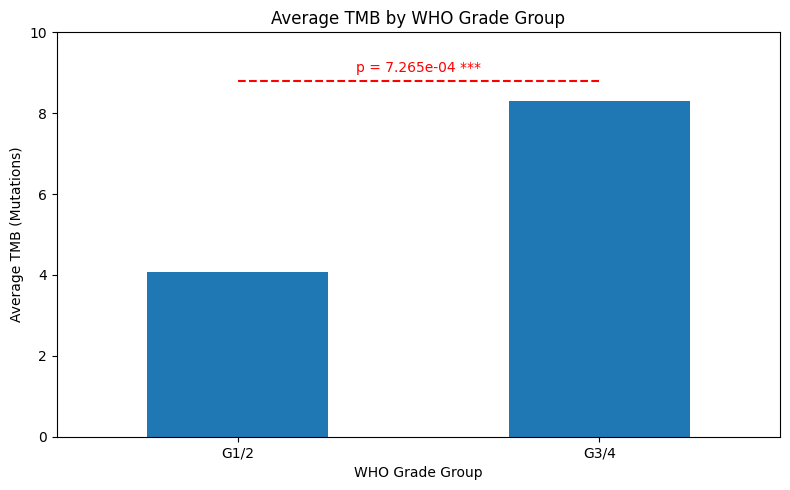

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Sample data creation (Replace this with your actual merged_df_clean)
# merged_df_clean = pd.read_csv('path_to_your_data.csv')

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Filter out 'Indeterminate' values
filtered_df = patients_df[patients_df['WHO Grade'] != 'Indeterminate'].copy()

# Step 3: Create a new column for grouped WHO Grades
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})

# Step 4: Calculate average TMB for each group
average_tmb = filtered_df.groupby('WHO Grade Grouped')['TMB (nonsynonymous)'].mean().reset_index()

# Step 5: Perform t-test between G1/2 and G3/4
g1_2_tmb = filtered_df[filtered_df['WHO Grade Grouped'] == 'G1/2']['TMB (nonsynonymous)']
g3_4_tmb = filtered_df[filtered_df['WHO Grade Grouped'] == 'G3/4']['TMB (nonsynonymous)']

t_stat, p_value = ttest_ind(g1_2_tmb, g3_4_tmb, equal_var=False)

# Step 6: Prepare for plotting
ax = average_tmb.plot(kind='bar', x='WHO Grade Grouped', y='TMB (nonsynonymous)', figsize=(8, 5), legend=False)

# Step 7: Customize the plot
ax.set_ylabel('Average TMB (Mutations)')
ax.set_xlabel('WHO Grade Group')
ax.set_title('Average TMB by WHO Grade Group')
ax.set_ylim(0, 10)  # Set y-axis limit to 10
plt.xticks(rotation=0)

# Step 8: Annotate the plot with p-value significance
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'NS'

# Calculate the position for the p-value line
x_pos = 0.5  # Position for the line between bars
y_pos = max(average_tmb['TMB (nonsynonymous)']) + 0.5  # Position slightly above the bars

# Add the line for p-value
ax.hlines(y=y_pos, xmin=0, xmax=1, color='red', linestyle='--')

# Add the p-value text above the line
ax.text(x_pos, y_pos + 0.2, f'p = {p_value:.3e} {significance}', ha='center', color='red')

# Step 9: Display the plot
plt.tight_layout()
plt.show()


<ipython-input-161-b7052d913ead>:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '*' * (p < 0.05) +
<ipython-input-161-b7052d913ead>:52: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '**' * (p < 0.01) +
<ipython-input-161-b7052d913ead>:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '***' * (p < 0.001),


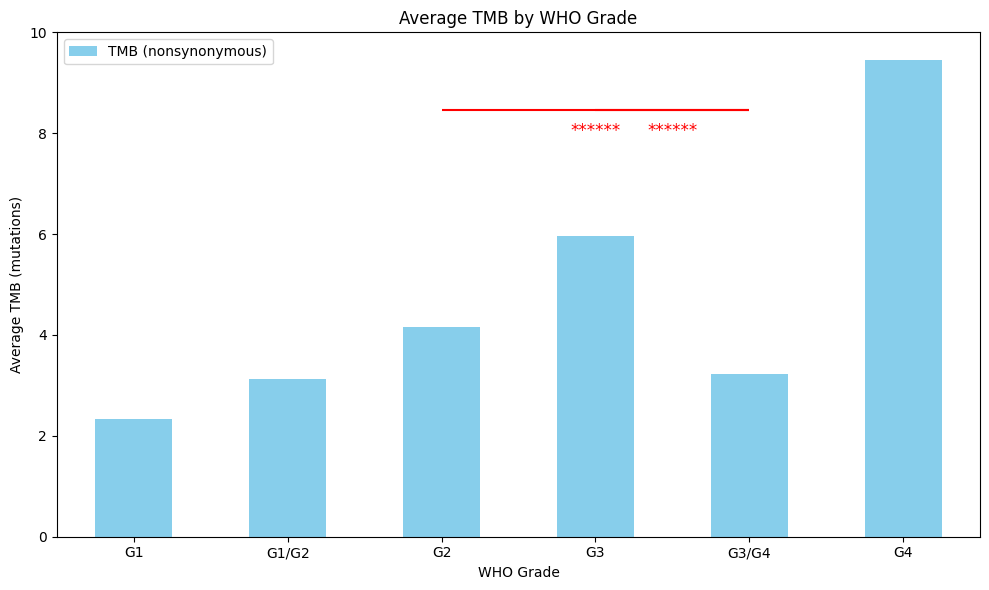

Significant Pairwise P-values: {'G2 vs G3/G4': -0.9241, 'G3 vs G3/G4': -2.7352}


In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Step 1: Filter out 'Indeterminate' values and keep one patient per Patient ID
filtered_df = merged_df_clean[merged_df_clean['WHO Grade'] != 'Indeterminate']
patients_df = filtered_df.groupby('Patient ID').first().reset_index()

# Step 2: Calculate the average TMB for each WHO Grade
average_tmb = patients_df.groupby('WHO Grade')['TMB (nonsynonymous)'].mean().reset_index()

# Step 3: Perform Kruskal-Wallis H-test for initial comparison
h_stat, p_value = kruskal(
    *[group['TMB (nonsynonymous)'].values for name, group in patients_df.groupby('WHO Grade')]
)

# Step 4: Perform pairwise comparisons using Tukey's HSD
tukey_results = pairwise_tukeyhsd(endog=patients_df['TMB (nonsynonymous)'],
                                   groups=patients_df['WHO Grade'],
                                   alpha=0.05)

# Extract p-values for pairwise comparisons
pairwise_p_values = {}
for comparison in tukey_results.summary().data[1:]:
    grade1, grade2, p_val, reject = comparison[0], comparison[1], comparison[2], comparison[3]
    if p_val < 0.05:  # Only keep significant p-values
        pairwise_p_values[f'{grade1} vs {grade2}'] = p_val

# Step 5: Plot the data
ax = average_tmb.plot(kind='bar', x='WHO Grade', y='TMB (nonsynonymous)',
                       figsize=(10, 6), ylim=(0, 10), color='skyblue')

# Step 6: Customize the plot
ax.set_ylabel('Average TMB (mutations)')
ax.set_title('Average TMB by WHO Grade')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Step 7: Annotate the plot with significant p-values and connect bars
for comparison, p in pairwise_p_values.items():
    grade1, grade2 = comparison.split(' vs ')
    x1 = average_tmb[average_tmb['WHO Grade'] == grade1].index[0]
    x2 = average_tmb[average_tmb['WHO Grade'] == grade2].index[0]

    # Position for the p-value line
    y_position = max(average_tmb['TMB (nonsynonymous)']) - 1  # Lower the p-value line
    ax.hlines(y=y_position, xmin=x1, xmax=x2, color='red')

    # Add p-value annotation below the line
    ax.text((x1 + x2) / 2, y_position - 0.5,
            '*' * (p < 0.05) +
            '**' * (p < 0.01) +
            '***' * (p < 0.001),
            ha='center', color='red', fontsize=12)

# Step 8: Show the plot
plt.tight_layout()
plt.show()

# Print the significant pairwise p-values
print("Significant Pairwise P-values:", pairwise_p_values)


**Let's calculate the percentage of patients with mutations in different pre-defined pathways**

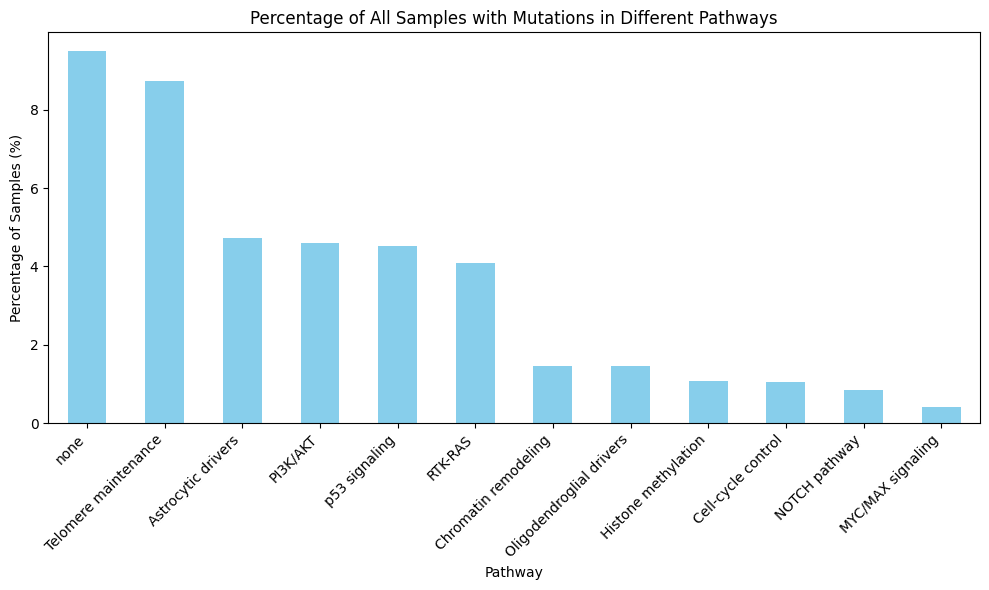

In [63]:
# Step 1: Count the total number of samples (regardless of IDH status)
total_samples = len(merged_df_clean)

# Step 2: Group by Pathway and count the number of unique samples for each pathway
pathway_counts = merged_df_clean.groupby('Pathway')['Tumor_Sample_Barcode'].nunique()

# Step 3: Calculate the percentage of samples in each pathway
pathway_percentages = (pathway_counts / total_samples) * 100

# Step 4: Sort pathways by percentage for better visualization (optional)
pathway_percentages = pathway_percentages.sort_values(ascending=False)

# Step 5: Plot the percentages using a bar plot
plt.figure(figsize=(10, 6))
pathway_percentages.plot(kind='bar', color='skyblue')

# Step 6: Customize the plot
plt.title('Percentage of All Samples with Mutations in Different Pathways')
plt.xlabel('Pathway')
plt.ylabel('Percentage of Samples (%)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()

# Step 7: Show the plot
plt.show()

In [77]:
p

1.0

Divid samples to the WHO classes 1/2 and 3/4, and do the chi-2 test to see, which differences between groups are significant

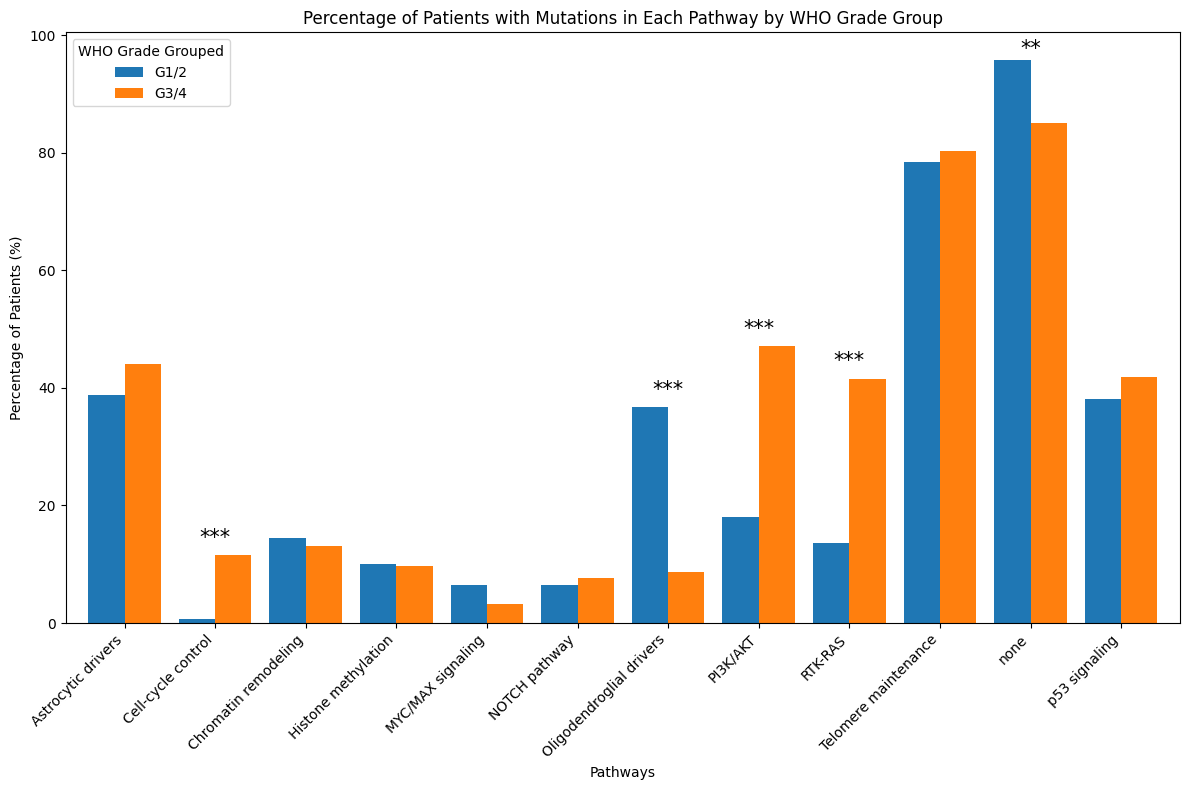

In [93]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Step 1: Count unique patients in each pathway and WHO grade group
pathway_counts = filtered_df.groupby(['Pathway', 'WHO Grade Grouped'])['Patient ID'].nunique().unstack()

# Step 2: Calculate the total number of patients for each WHO group
total_patients_per_who_group = filtered_df.groupby('WHO Grade Grouped')['Patient ID'].nunique()

# Step 3: Calculate the percentage of patients in each pathway within each WHO grade group
pathway_perc_within_who = pathway_counts.div(total_patients_per_who_group, axis=1) * 100

# Initialize a dictionary to store p-values
p_values = {}

# Step 4: Perform chi-square test for each pathway between G1/2 and G3/4
for pathway in pathway_counts.index:
    # Extract counts for the pathway in G1/2 and G3/4 groups
    counts = pathway_counts.loc[pathway]

    # Check if there are non-zero values in both G1/2 and G3/4 groups
    if not counts.isnull().values.any():  # Ensure there are no NaN values
        # Construct contingency table for chi-square test
        contingency_table = [
            [counts['G1/2'], total_patients_per_who_group['G1/2'] - counts['G1/2']],
            [counts['G3/4'], total_patients_per_who_group['G3/4'] - counts['G3/4']]
        ]

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Store the p-value
        p_values[pathway] = p
    else:
        p_values[pathway] = 1.0  # Assign a p-value of 1.0 if there are missing values

# Step 5: Plot the data
ax = pathway_perc_within_who.plot(kind='bar', stacked=False, figsize=(12, 8), width=0.8)

# Step 6: Customize the plot
ax.set_ylabel('Percentage of Patients (%)')
ax.set_xlabel('Pathways')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by WHO Grade Group')
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='WHO Grade Grouped')

# Step 7: Annotate the plot with significant p-values
for i, pathway in enumerate(pathway_counts.index):
    p = p_values[pathway]

    # If p-value is significant, add stars to the plot (only once)
    if p < 0.001:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]) + 2, '***', ha='center', color='black', fontsize=15)
    elif p < 0.01:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]) + 1, '**', ha='center', color='black', fontsize=15)
    elif p < 0.05:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]), '*', ha='center', color='black', fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()
